# Librerias

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
# Números y Datos
import numpy as np
import networkx as nx
from networkx.algorithms.approximation import average_clustering
import community.community_louvain as cl
import pickle

# Bajar Datos

In [2]:
# DATOS REDES:
#!wget -O airport.txt https://www.dropbox.com/scl/fi/nk8yvhez5ylhd6blzf77o/airport.txt?rlkey=3cf24r6yij8uu0fakb68yztlm&dl=1
#!wget -O facebook.txt https://www.dropbox.com/scl/fi/hdgcmyss47w9t676kh2ug/facebook.txt?rlkey=j616y86ejfn6f719jg4b8e413&dl=1
!wget -O lesmiserables.txt https://www.dropbox.com/scl/fi/ex7183k4zjgxbiw0diwi3/lesmiserables.txt?rlkey=zx5u5371s7gw3jlv50363jycf&dl=1
#!wget -O terrorist.txt https://www.dropbox.com/scl/fi/2vl6hcazv5v13r7scodod/terrorist.txt?rlkey=l0n1rxbby6a8irtlyh1tbbweo&dl=1
#!wget -O celegans.txt https://www.dropbox.com/scl/fi/t62q9swnah7nvu34falkj/celegans.txt?rlkey=lxg2kashijntfi0bwmeuty5ja&dl=1
!wget -O email.txt https://www.dropbox.com/scl/fi/w5o34b0olg7xek4s42lml/email-Eu-core.txt?rlkey=g2561imdd4ssyrwfgywrotzwm&st=czqgmef0&dl=1
!wget -O email_labels.txt  https://www.dropbox.com/scl/fi/ij3b6jul7ispiovt18sfm/email-Eu-core-department-labels.txt?rlkey=dqp60qw20pw7biil9cvti4u68&st=zij9wsi8&dl=1


# AHORA ARCHIVOS DE POSICION DE LOS NODOS:
#!wget -O airportStronglyConn_pos.pkl https://www.dropbox.com/scl/fi/eebzjgqazi8b02bkkrxmf/airStrongly_positions.pkl?rlkey=cyhifzsgrls5vdlycrb1gnykv&st=6lozmqe6&dl=1
!wget -O email_pos.pkl https://www.dropbox.com/scl/fi/loeuul6gxq7uscd1m7ks8/email_positions.pkl?rlkey=caf194s8198pffo2zaq6767jz&st=kw0c3tu4&dl=1
#!wget -O fb_pos.pkl https://www.dropbox.com/scl/fi/ka6v0h9ew5j08haxlbf6b/fb_positions.pkl?rlkey=7ul7jr7re5bziy54cgp3x9tre&st=vp6gjciw&dl=1

--2025-04-25 18:50:37--  https://www.dropbox.com/scl/fi/ex7183k4zjgxbiw0diwi3/lesmiserables.txt?rlkey=zx5u5371s7gw3jlv50363jycf
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucadfea27c015da257eb97c43277.dl.dropboxusercontent.com/cd/0/inline/CofO9qjg8jM1H7N12xPOBKnWZDORgnoQ8cnMv9v1Qc5cYzrtfpPpsUG7GgLpp747iDjbtaTMTF6Fkb5xzAwlrs5GsejYX6MKRVrjsqfVQ9QYlWsFYGHBBV6hOtSvBMArhFKULWzaollkZEI3jBiLqmWR/file# [following]
--2025-04-25 18:50:38--  https://ucadfea27c015da257eb97c43277.dl.dropboxusercontent.com/cd/0/inline/CofO9qjg8jM1H7N12xPOBKnWZDORgnoQ8cnMv9v1Qc5cYzrtfpPpsUG7GgLpp747iDjbtaTMTF6Fkb5xzAwlrs5GsejYX6MKRVrjsqfVQ9QYlWsFYGHBBV6hOtSvBMArhFKULWzaollkZEI3jBiLqmWR/file
Resolving ucadfea27c015da257eb97c43277.dl.dropboxusercontent.com (ucadfea27c015da257eb97c43277.dl.dropboxusercontent.com)... 162.125.1.15, 2

# Funciones útiles

**Para cargar datos**

In [3]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G


def read_graph_weighted(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

def read_dir_graph(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

def read_dir_graph_weighted(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

In [4]:
def get_graph_pos(filename):
  with open(filename, 'rb') as f:
    posData = pickle.load(f)
  return posData

**Borrarle los pesos a un grafo pesado**

In [5]:
def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

**Para calcular eficientemente en grafos muy grandes una aproximación a distancias mínimas medias, $<d>$**

In [6]:
# especialmente útil en grafos grandes, como el de facebook
def sample_path_lengths(G, nodes=None, trials=1000):
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)

    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair)
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

# Preludio

**Veamos características de las redes**

In [11]:
email = read_graph('email.txt')
print('Email')
print(email)
print('Es dirigido?:',nx.is_directed(email))
print('Es pesado?:',nx.is_weighted(email))
print('Es conectado?:',nx.is_connected(email))
print('La densidad es de: ', nx.density(email))
print('El coeficiente de clustering promedio es:', nx.average_clustering(email))
#print('La distancia media es:', nx.average_shortest_path_length(email))
print('La eficiencia global es: ', nx.global_efficiency(email))
print('El número de componentes es: ', nx.number_connected_components(email))
print('')

lesmis= read_graph_weighted('lesmiserables.txt')
print('Les Miserables')
print(lesmis)
print('Es dirigido?:',nx.is_directed(lesmis))
print('Es pesado?:',nx.is_weighted(lesmis))
print('Es conectado?:',nx.is_connected(lesmis))
print('La densidad es de: ', nx.density(lesmis))
print('El coeficiente de clustering es:', nx.average_clustering(lesmis))
print('La distancia media es:', nx.average_shortest_path_length(lesmis))
print('La eficiencia global es: ', nx.global_efficiency(lesmis))
print('El número de componentes es: ', nx.number_connected_components(lesmis))


Email
Graph with 1005 nodes and 16706 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: False
La densidad es de:  0.03311331787278746
El coeficiente de clustering promedio es: 0.3993549664221539
La eficiencia global es:  0.40433941089132175
El número de componentes es:  20

Les Miserables
Graph with 77 nodes and 254 edges
Es dirigido?: False
Es pesado?: True
Es conectado?: True
La densidad es de:  0.08680792891319207
El coeficiente de clustering es: 0.5731367499320135
La distancia media es: 2.6411483253588517
La eficiencia global es:  0.43528708133971505
El número de componentes es:  1


# Version no pesadas de Los Miserables





In [12]:
lesmisU = lesmis.copy()
drop_weights(lesmisU)
print('Les Miserables (unweighted)')
print(lesmisU)
print('Es dirigido?:',nx.is_directed(lesmisU))
print('Es pesado?:',nx.is_weighted(lesmisU))
print('Es conectado?:',nx.is_connected(lesmisU))
print('')

Les Miserables (unweighted)
Graph with 77 nodes and 254 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: True



Vamos a leer los labels del dataset $Email$ (a qué departamento pertenece cada nodo):

In [ ]:
array = np.loadtxt('email_labels.txt', dtype=int)
labelsEmail=list(array[:,1])
df=pd.DataFrame(labelsEmail)
display(df)

¿Cuál es la componente gigante del grafo Email?

In [17]:
G=email
G.remove_edges_from(nx.selfloop_edges(G)) # Borro autoenlaces
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
emailGiant = G.subgraph(Gcc[0])
print(emailGiant)
print('Es dirigido?:',nx.is_directed(emailGiant))
print('Es pesado?:',nx.is_weighted(emailGiant))
print('Es conectado?:',nx.is_connected(emailGiant))
print('')

Graph with 986 nodes and 16064 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: True





**¿Cómo lidar con grafos muy grandes?**

**Camino mínimo medio**

Para grafos no pesados (dirigdos o no dirigidos), el algoritmo que usa la librería Networkx es [Breadth-first search](https://en.wikipedia.org/wiki/Breadth-first_search), que escalea $O(nodos+enlaces)$

Para grafos pesados (no dirigidos), el algoritmo que se usa es el de [Dijkstra](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm), que escalea $O(nodos^2)$. Si el grafo es dirigo usa una variante del algoritmo (de Fredman & Tarjan) que escalea $O(enlaces+nodos \log(nodos))$



In [18]:
print('Dos cálculos de caminos mínimos medios')
## DISTANCIAS
# ESTO DEMORA MAS DE 1 MINUTO
print(nx.average_shortest_path_length(emailGiant))

# ESTO DEMORA MENOS DE 1 SEGUNDO
print(estimate_path_length(emailGiant))
print('')

print('Dos cálculos de coeficiente de clustering medio')
## COEFICIENTE DE CLUSTERING
# ESTO DEMORA 4 SEGUNDOS
print(nx.average_clustering(emailGiant))

# ESTO MENOS DE 1 SEGUNDO
print(average_clustering(emailGiant, trials=1000))

Dos cálculos de caminos mínimos medios
2.586933824816466
2.601

Dos cálculos de coeficiente de clustering medio
0.40705044751953817
0.386


### Spring Layout: posición espacial de los nodos en el grafo
Para graficar grafos, es útil usar el layout de "resortes" para encontrar una posición espacial "óptima" de los nodos ("óptima" en el sentido que representa mejor la organización general del grafo).

Para obtener este layout, se considera una lucha entre dos fuerzas antagónicas: una en la que los nodos se "repelen" entre sí, y otra en la que los pares de nodos conectados se acercan gracias a los enlaces que los unen (que funcionan como "resortes"). De esta manera los nodos más interconectados van a agruparse en una posición espacial del grafo. La simulación corre un número de iteriaciones (controlada por el parámetro $iterations$) hasta llegar a un equilibrio.

*Opcional:* un parámetro extra opcional, el parámetro $k$, que fuerza una distancia óptima entre nodos (cuanto menor más se agrupan todos los nodos en el centro; si lo agrando va a posicionar los nodos menos conectados más en la periferia del grafo). Esto serviría si luego de correr la simulación, el layout resultante es una bola de nodos en el centro. En ese caso hay que probar a mano con varios valores de $k$ (en el rango 0.1 - 10, por ejemplo) para ver si mejora el layout.

In [19]:
# Se corre así para un grafo "G", y me devuelve un diccionario "pos" de posiciones
pos = nx.spring_layout(lesmisU,iterations=1000)

# Opcional, con parámetro "k"
# pos = nx.spring_layout(G,iterations=1000, k=0.5)

Para grafos muy grandes puede demorar (por ej., 20 mins para el grafo de Facebook), así que estas son las posiciones pre-computadas (con $iterations$=1000 y $k$=None):

In [34]:
pos_emailOri=get_graph_pos('email_pos.pkl')

Calculo de antemano las posiciones para el resto de los grafos:

In [32]:
pos_lesmis = nx.spring_layout(lesmis,iterations=1000)
pos_email = nx.spring_layout(email,iterations=1000)
pos_emailGiant = nx.spring_layout(emailGiant,iterations=100000)

KeyboardInterrupt: 

### ¿Cómo graficar redes pesadas?
Ahora defino una función útil para graficar redes pesadas donde el ancho de los enlaces es proporcional al peso. Puede ser un proceso lento si el grafo es demasiado grande (en ese caso usar nx.draw como siempre y no darle diferentes anchos a los enlaces).

El parametro $magnification$ calibra cuanto se suaviza o exagera la diferencia entre los anchos de los enlaces.
El parámetro $colorMapping$ es un diccionario donde a cada nodo se le asigna un valor numérico que se puede mapear a un color. Por ej., puede ser la centralidad de un nodo, que se va a representar en una escala de colores

In [25]:
def plotWeightedGraph(G,pos,colorMapping,magnification,nodeSize=45,title=None):
  values = [v for n,v in colorMapping.items()]
  nx.draw_networkx_nodes(G,pos=pos,node_size=nodeSize, node_color = values)
  nx.draw_networkx_labels(G,pos,{n:n for n in G.nodes()},font_size=7,font_color='white')

  edge_weights = nx.get_edge_attributes(G, "weight")
  edgeWidths=np.array(list(edge_weights.values()))
  edgeWidths=magnification*edgeWidths/np.max(edgeWidths)
  edgeWidths[edgeWidths>0]=edgeWidths[edgeWidths>0]-np.min(edgeWidths[edgeWidths>0])+.5

  nx.draw_networkx_edges(G, pos, edgelist=G.edges(),width=edgeWidths,edge_color='gray')

  if title:
        plt.title(title)

Visualicemos las redes con spring layout
- Les Miserables
- Emails



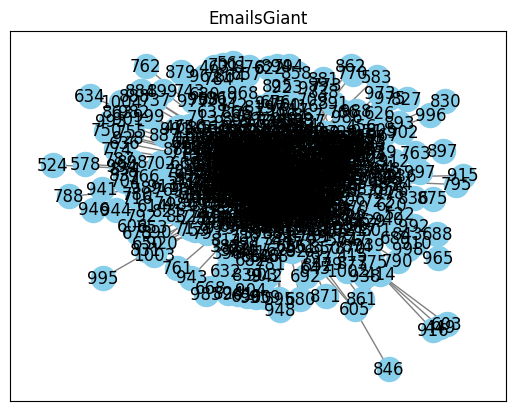

In [35]:
G=lesmis
centrality = nx.degree_centrality(G)
magnification=1
nodeSize=60
plotWeightedGraph(G,pos_lesmis,centrality,magnification,nodeSize,'Les Miserables')
plt.show()

G=email
centrality = nx.degree_centrality(G)
magnification=1
nodeSize=60
nx.draw_networkx(G, pos_email, with_labels=True, node_color="skyblue", edge_color="gray", width=1.0)
plt.title("Emails")
plt.show()

G=emailGiant
centrality = nx.degree_centrality(G)
magnification=1
nodeSize=60
nx.draw_networkx(G, pos_emailOri, with_labels=True, node_color="skyblue", edge_color="gray", width=1.0)
plt.title("EmailsGiant")
plt.show()

### ¿Cómo resaltamos un atributo de un nodo (por ej., centralidad) al graficar un grafo?

In [ ]:
def plotNodeAttribute(G,pos,attribute,exaggeration):
  values = [v for n,v in attribute.items()]
  nsize = np.array (values)
  nsize = exaggeration*( nsize - min(nsize))/(max(nsize) - min(nsize))
  nx.draw(G,pos=pos, node_size = nsize, alpha=0.4,node_color = values, edge_color='gray')

Por ejemplo, para el dataset *Terroristas* (obviando el peso de los enlaces):


NetworkXError: Node np.int64(580) has no position.

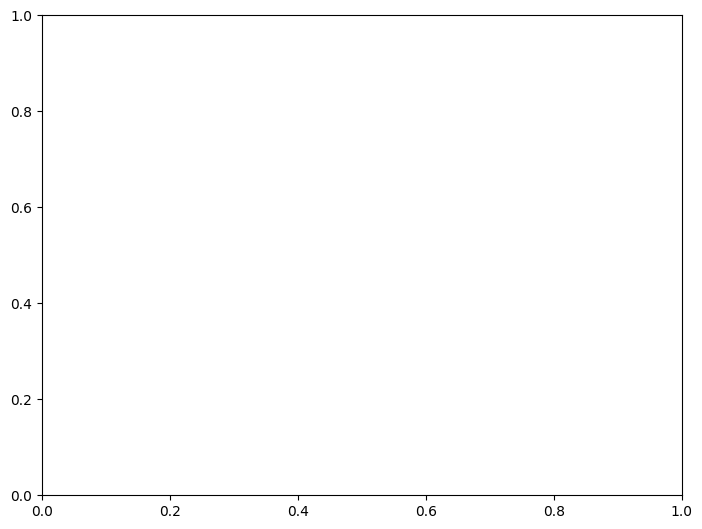

In [ ]:
exaggeration=100
plotNodeAttribute(G,pos_email,centrality,exaggeration)